# Forgery detection in digital images via discrete wavelet and discrete cosine transforms

## Importing The Libraries And Images 

In [6]:
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct

## Image Loading And Preprocessing

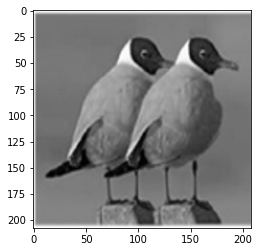

In [7]:

image = Image.open('images/birds.png')
image = image.resize((208,208))
ycbcr = image.convert('YCbCr')

y, cb, cr = ycbcr.split()
plt.imshow(y,"gray")

## DWT Transformations
```
                           -------------------
                            |        |        |
                            | cA(LL) | cH(LH) |
                            |        |        |
(cA, (cH, cV, cD))  <--->   -------------------
                            |        |        |
                            | cV(HL) | cD(HH) |
                            |        |        |
                            -------------------
```

## Level 1 DWT Applied

In [8]:
## Extract the lowest coefficient
from pywt import dwt2
coeff = dwt2(y, wavelet='haar')
cA, (cH, cV, cD) = coeff
cA.shape

(104, 104)

In [9]:
## Block Size Kept !
block_row = 8
block_col = 8

## Sliding Window Algorithm (Divide Into OVerlapping Blocks)

In [10]:
tiles = np.zeros((int(cA.shape[0] - block_row + 1) * int(cA.shape[1] - block_col + 1), block_row, block_col ))
c = 0
for i in range(0,cA.shape[0] - block_row + 1, 1):
    for j in range(0,cA.shape[1]-block_col+1,1):
        # print(j)
        tiles[c] = cA[i:i+8 ,j:j+8]
        # print(tiles[c])
        c+=1 
print("Tiles Shape: ",tiles.shape)

Tiles Shape:  (9409, 8, 8)


## DCT 

In [11]:
##DCT apply to each and every block

# implement 2D DCT
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

In [12]:
dct_tiles = np.zeros((tiles.shape[0], block_row, block_col))
for i in range(len(tiles)):
    dct_tiles[i] = dct2(tiles[i])

### now we have high frequency components in the system 

## Row Vector Conversion

In [13]:
# block_row = 8
# block_col = 8

zig_zag_matrixes = np.zeros(((cA.shape[0]- block_row + 1)*(cA.shape[0]- block_col + 1), block_row*block_col)) 

for mat in tqdm(range(len(dct_tiles))):
    solution=[[] for i in range(block_row+block_col-1)]
    matrix = dct_tiles[mat]
    for i in range(block_row):
        for j in range(block_col):
            sum=i+j
            if(sum%2 ==0):

                #add at beginning
                solution[sum].insert(0,matrix[i][j])
            else:

                #add at end of the list
                solution[sum].append(matrix[i][j])

    # # print the solution as it as
    final = list()
    # print(solution)
    for i in solution:
        for j in i:
            final.append(j)

    # print("Print:",np.array(final).shape)
    zig_zag_matrixes[mat] = np.array(final)


100%|██████████| 9409/9409 [00:00<00:00, 10102.26it/s]


## Lexographical Sorting

In [14]:
## Lexographical Sorting 
# https://github.com/revanthpendyala/Image-Forgery-Detection/blob/master/forgery_detect/features.py

from copy import deepcopy
from collections import OrderedDict
from operator import itemgetter
def lex_order(matrix):
	mat = deepcopy(matrix)
	k = mat.shape[0]
	mat_data = {}
	for i in range(1,k+1):
		mat_data[i] = list(mat[i-1])

	orig_data = mat_data
	mat_data = OrderedDict(sorted(mat_data.items(), key=itemgetter(1)))

	return orig_data, mat_data

In [15]:
original_data,mat_data = lex_order(zig_zag_matrixes)
original_data==mat_data

True

In [16]:
zig_zag_matrixes.shape

(9409, 64)

## Correlation Coefficients

In [17]:
a = np.corrcoef(zig_zag_matrixes)

In [18]:
a.shape

(9409, 9409)

In [19]:
## Checking if the values of coefficients are between -1 to 1 

# count = 0
# for i in tqdm(range(a.shape[0])):
#     for j in range(a.shape[1]):
#         if not -1 <= a[i][j] <= 1:
#             count += 1
# print(count)

## Testing (Step 7)

In [20]:
# Store the Duplicate array indexes an array
duplicated_blocks = []
threshold = 0.2
for i in tqdm(range((a.shape[0]))):
    for j in range((a.shape[1])):
        if abs(a[i][j]) < threshold:
            duplicated_blocks.append((i,j))

100%|██████████| 9409/9409 [01:00<00:00, 155.85it/s]


In [21]:
duplicated_blocks

[(6800, 7190), (6895, 7190), (7190, 6800), (7190, 6895)]